This notebook contains the necessary scripts for making the base case model.

In [1]:
### Starting with the import of the necessary libraries:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
from scipy.stats import linregress
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

C:\Users\po7517\Anaconda3\envs\new_env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\po7517\Anaconda3\envs\new_env\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\po7517\Anaconda3\envs\new_env\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
### either CPU or GPU:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [8]:
### Reading the dummy data
all_data = pd.read_csv('data/all_data_dummy.csv')

In [9]:
def pytorch_NN(all_data, input_features, target_variables, weight_decay=1e-4, patience=50):
    '''
    This function reads the data and based on the interest of the user, different 
    input features and target variables can be selected from the existing measured
    parameters.
    weight_decay is a regularization technique used to prevent overfitting by penalizing 
    large weights in the model. More details at 
    https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    patience refers to the number of training epochs to wait after the last improvement 
    in the monitored metric (e.g., validation loss, accuracy) before stopping the training process.
    More details at https://pytorch.org/ignite/generated/ignite.handlers.early_stopping.EarlyStopping.html
    '''
    ### The next block of code prepares the data
    X = all_data[input_features].to_numpy()
    y = all_data[target_variables].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    scaler_x = RobustScaler()
    scaler_y = RobustScaler()
    X_train_norm = scaler_x.fit_transform(X_train)
    X_test_norm = scaler_x.transform(X_test)
    y_train_norm = scaler_y.fit_transform(y_train)
    y_test_norm = scaler_y.transform(y_test)
    XX = torch.from_numpy(X_train_norm.astype(np.float32)).to(device)
    yy = torch.from_numpy(y_train_norm.astype(np.float32)).to(device)
    n_samples, n_features = XX.shape
    input_size = n_features
    output_size = yy.shape[1]
    
    class NN(nn.Module):
        def __init__(self):
            super(NN, self).__init__()
            self.fc1 = nn.Linear(n_features, 86) # Input layer to hidden layer
            self.norm1 = nn.BatchNorm1d(86) # Batch normalization
            self.fc2 = nn.Linear(86, 32) # Hidden layer to hidden layer
            self.norm2 = nn.BatchNorm1d(32) # Batch normalization
            self.fc3 = nn.Linear(32, 32) # Hidden layer to hidden layer
            self.norm3 = nn.BatchNorm1d(32) # Batch normalization
            self.fc4 = nn.Linear(32, output_size) # Hidden layer to output layer

        def forward(self, x):
            x = torch.relu(self.fc1(x)) # applying relu activation
            x = self.norm1(x) # applying the batch normalization
            x = torch.relu(self.fc2(x))
            x = self.norm2(x)
            x = torch.relu(self.fc3(x))
            x = self.norm3(x)
            x = self.fc4(x)
            return x
 
    model = NN().to(device) # contruction of the model

    # Define the loss function and optimizer
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)

    # Training loop with early stopping
    num_epochs = 2000
    best_loss = float('inf')
    patience_counter = 0
    loss_values = []
    loss_train = []
    for epoch in range(num_epochs):
        def closure():
            optimizer.zero_grad()
            outputs = model(XX)
            loss = criterion(outputs, yy)
            loss.backward()
            loss_train.append(loss.item())
            return loss

        # Perform optimization step
        optimizer.step(closure)

        model.eval()
        with torch.no_grad():
            val_outputs = model(torch.from_numpy(X_test_norm.astype(np.float32)).to(device))
            val_loss = criterion(val_outputs, torch.from_numpy(y_test_norm.astype(np.float32)).to(device))

        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience: # looking for the improve of the loss
            print(f'Early stopping at epoch {epoch+1}')
            break

        if (epoch+1) % 100 == 0: # printg out each 100th epoch
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

        loss_values.append(val_loss.item())

    print("Training complete.")
    # using the trained model to predict for the test data
    predicted = model(torch.from_numpy(X_test_norm.astype(np.float32)).to(device)).detach().cpu().numpy()
    predicted_original_scale = scaler_y.inverse_transform(predicted)
    y_test_original_scale = scaler_y.inverse_transform(y_test_norm)
    
    # using the trained model to predict for the train data
    predicted_tr = model(torch.from_numpy(X_train_norm.astype(np.float32)).to(device)).detach().cpu().numpy()
    predicted_original_scale_tr = scaler_y.inverse_transform(predicted_tr)
    y_train_original_scale = scaler_y.inverse_transform(y_train_norm)

    r_values = [] # collects the r value between the measured test and predicted test cases
    for i in range(len(target_variables)):
        slope, intercept, r_value, p_value, std_err = linregress(y_test_original_scale[:, i], predicted_original_scale[:, i])
        r_values.append(r_value)
    
    return r_values, y_test_original_scale, predicted_original_scale, y_train_original_scale, predicted_original_scale_tr, loss_train, loss_values 

In [10]:
target_variables = ['B', 'V', 'Cr', 'Mn', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Be',
                    'As', 'Rb', 'Sr', 'Y', 'Mo', 'Cd', 'Sb', 'Cs', 'Ba', 'Pb'] # to be predicted
input_features = ['Li', 'Na', 'Ca', 'SO-', 'Cl-', 'Br-', 'Al', 'Si', 'pH', 'F-', 'Fe', 'Mg']
import time
start = time.time()
results = []
### Making an ensemble of 1000 models
for i in range(1000):
    print(f'Starting Round {i}')
    r_values, test_y, predicted_y, train_y, predicted_y_train, l_tr, l_te = pytorch_NN(all_data, input_features, target_variables)
    results.append({
        'r_values': r_values,
        'test_y': test_y,
        'predicted_y': predicted_y,
        'train_y': train_y,
        'predicted_y_train': predicted_y_train,
        'l_tr': l_tr,
        'l_te': l_te,
    })
end = time.time()
print(f'{(end - start)/60} mins')

Starting Round 0
Early stopping at epoch 62
Training complete.
Starting Round 1
Early stopping at epoch 58
Training complete.
Starting Round 2
Early stopping at epoch 56
Training complete.
Starting Round 3
Early stopping at epoch 66
Training complete.
Starting Round 4
Early stopping at epoch 55
Training complete.
Starting Round 5
Early stopping at epoch 52
Training complete.
Starting Round 6
Early stopping at epoch 55
Training complete.
Starting Round 7
Early stopping at epoch 59
Training complete.
Starting Round 8
Early stopping at epoch 60
Training complete.
Starting Round 9
Early stopping at epoch 56
Training complete.
Starting Round 10
Early stopping at epoch 52
Training complete.
Starting Round 11
Early stopping at epoch 57
Training complete.
Starting Round 12
Early stopping at epoch 53
Training complete.
Starting Round 13
Early stopping at epoch 51
Training complete.
Starting Round 14
Early stopping at epoch 53
Training complete.
Starting Round 15
Early stopping at epoch 56
Train

In [11]:
### Separating the R2 score of each model
r_squared_values = [[r**2 for r in result['r_values']] for result in results]
df = pd.DataFrame(r_squared_values, columns=target_variables)
df_melted = df.melt(var_name='Element', value_name='R_squared')

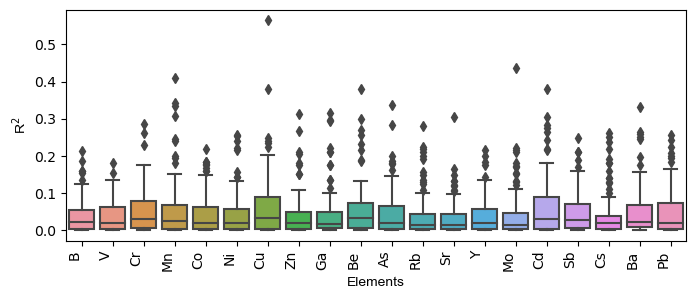

In [12]:
### Making a plot to have a view on the R2 score for each predicted element
fig, ax = plt.subplots(1,1, figsize=(8,3))
sns.boxplot(data=df_melted, x='Element', y='R_squared')
plt.xlabel('Elements', fontname = "Arial", fontsize=10)
plt.ylabel('R$^2$', fontname = "Arial", fontsize=10)
plt.xticks(rotation=90, ha='right')
plt.show()